In [2]:
import pandas as pd
import numpy as np

def loader():
    """Reading data from keys"""
    with open("data/keys.txt", "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("data/data_{}.csv".format(str(key)))

    return dictex

In [15]:
df = loader()

In [10]:
# from horizon_handler
HORIZON_FEATURES = ['radiation', 'shade']

# from SMHI
FCST_FEATURES = ['AirTemp', 'DewPoint', 'RainPrecip', 'SnowPrecip', 'SnowPrecipAccumulated', 'WindSpeed',
                 'AirPressure', 'OctalCloudCoverage', 'PrecipAmount']
# from METRo
EBM_FEATURES = ['air_temp', 'dew_point', 'surf_temp', 'water_amount', 'snow_amount', 'sub_temp']


# setting the independent and dependent features
INDEPENDENT_FEATURES = HORIZON_FEATURES + FCST_FEATURES + EBM_FEATURES

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
import sys
import pickle

def get_best_value_of_k(samples, targets, ran):
    best_k_value = 0
    best_score = 100
    for i in range(1, ran):
        model = KNeighborsRegressor(n_neighbors=i+1, 
                                algorithm='auto')
        scores = cross_val_score(model, samples, targets, cv=2)
        if (np.mean(scores)**2 < best_score):
            best_score = np.mean(scores)**2
            best_k_value = i+1
    return best_k_value, best_score

def incremental_fit(model, samples, targets):
    model.fit(samples, targets)
    return model

def fit_knn(samples, targets, k):
    model = KNeighborsRegressor(n_neighbors=k, 
                                algorithm='auto', 
                                weights='distance')
    model.fit(samples, targets)
    # print_feature_importance(samples, targets)
    return model

def print_feature_importance(samples, targets):
    print('Feature  Accuracy')
    for i in range(samples.shape[1]):
        X = samples[:, i].reshape(-1, 1)
        scores = cross_val_score(KNeighborsRegressor(), X, targets, scoring='neg_mean_squared_error')
        print(scores.mean())

def forecast_knn(model, samples):
    predictions = model.predict(samples)
    return predictions

def normalize(train, test):
    mean = train.mean(axis=0)    
    train -= mean
    std = train.std(axis=0)
    train /= std

    test -= mean
    test /= std
    return train, test

def getValues(data, raw=False):
    data.set_index("Date Time", inplace=True)
    included = np.array(data[INDEPENDENT_FEATURES + ['surf_temp_sqerror']].notnull().all(axis=1))

    rsi = {
        "data": data.loc[included, INDEPENDENT_FEATURES].values.astype(np.float), 
        "target": data.loc[included, 'surf_temp_sqerror'].values.astype(np.float)
    }
    
    if (raw):
        return train_test_split(rsi["data"], rsi["target"], test_size=0.0, random_state=0)
    return train_test_split(rsi["data"], rsi["target"], test_size=0.3, random_state=0)


In [18]:
dfTest = loader()
k_values = dict()

# (1419, 1) 5 0.026756253356757947
# (1419, 5) 100 0.229122459482671
# (1419, 9) 1 0.23085542684204077
# (1419, 18) 100 0.2547731413505692

def allowed_key(key):
    if  1 in key or 5 in key or 9 in key or 18 in key:
            return True
    return False

for key in dfTest.keys():
    if allowed_key(key):
        X_train, X_test, y_train, y_test = getValues(dfTest[key], raw=True)
        X_train, X_test = normalize(X_train, X_test)
        
        best_k_value, best_score = get_best_value_of_k(X_train, y_train, 10)
        k_values[key] = best_k_value
        print(key, best_k_value, best_score)
        

(1419, 1) 2 0.0011899662510712664
(1419, 5) 5 0.03188163067994646
(1419, 9) 10 0.13431944622691339
(1419, 18) 10 0.13391878173297633
(1433, 1) 3 0.011926150112634891
(1433, 5) 10 0.02024830916683474
(1433, 9) 10 0.03264657070837812
(1433, 18) 10 0.0842349469810978
(1440, 1) 10 0.009110952493917503
(1440, 5) 10 0.018086262447473037
(1440, 9) 10 0.06480199825664981
(1440, 18) 10 0.1758363936707969
(1417, 1) 10 0.00024804508545779147
(1417, 5) 2 0.0433746722840234
(1417, 9) 10 0.10817445093200047
(1417, 18) 10 0.1022078268017507


In [19]:
from matplotlib import pyplot
import matplotlib.pyplot as plt

def plotPredictions(key, true, predictions):
    plt.figure(figsize=(16,7))
    plt.subplot(121)
    pyplot.scatter(true, predictions, color="red", alpha=0.5, s=10)
    pyplot.xlim(0,20)
    pyplot.ylim(0,20)
    pyplot.plot(range(60), color='black', alpha=0.2)
    pyplot.grid()
    pyplot.title(key, fontsize=16)
    pyplot.xlabel('surf_temp_sqerror')
    pyplot.ylabel('Estimated surf_temp_sqerror')

In [22]:
def experiment(k_value, data, key):
    X_train, X_test, y_train, y_test = getValues(data)
    X_train, X_test = normalize(X_train, X_test)

    error_scores = list()
    print(key)
    knn_model = fit_knn(X_train, y_train, k_value)
    
    with open('models/knn/model_{}'.format(key), 'wb') as f:
        pickle.dump(knn_model, f)

    predictions = forecast_knn(knn_model, X_test)
    true = y_test

    # report performance
    mse = mean_squared_error(true, predictions)
    print('Test MSE: %.3f' % (mse))
    error_scores.append(mse)
    #plotPredictions(key, true, predictions)
    
    return true, predictions, error_scores, knn_model

In [48]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

df = loader()

trueVals = []
predictedVals = []
results = dict()
models = dict()

def allowed_key(key):
    if  1 in key or 5 in key or 9 in key or 18 in key:
            return True
    return False

for key in df.keys():
    if allowed_key(key):
        true, predictions, error_scores, knn_model = experiment(k_values[key], df[key], key)
        results[key] = error_scores
        models[key] = knn_model
        print(error_scores)
        trueVals.extend(true)
        predictedVals.extend(predictions)
    

(1419, 1)
Test MSE: 0.488
[0.4882450902856195]
(1419, 5)
Test MSE: 11.655
[11.654756282717189]
(1419, 9)
Test MSE: 10.347
[10.347323222819679]
(1419, 18)
Test MSE: 11.525
[11.524850275381814]
(1433, 1)
Test MSE: 0.283
[0.28340667792678037]
(1433, 5)
Test MSE: 3.836
[3.8357504532133793]
(1433, 9)
Test MSE: 5.712
[5.711691480642361]
(1433, 18)
Test MSE: 8.826
[8.826208432471903]
(1440, 1)
Test MSE: 0.142
[0.14157726462352307]
(1440, 5)
Test MSE: 1.622
[1.6215757321335242]
(1440, 9)
Test MSE: 2.530
[2.5296177692875665]
(1440, 18)
Test MSE: 4.103
[4.102942614610574]
(1417, 1)
Test MSE: 0.795
[0.7950698993650779]
(1417, 5)
Test MSE: 7.377
[7.376987201625352]
(1417, 9)
Test MSE: 10.151
[10.151057373526394]
(1417, 18)
Test MSE: 9.641
[9.640552156611335]


Text(0, 0.5, 'Estimated surf_temp_sqerror')

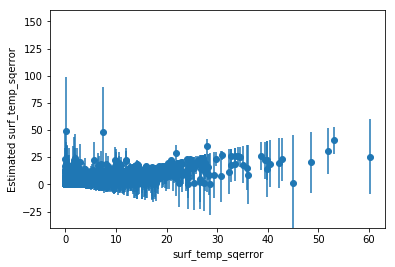

In [181]:
import math

diffValsSquared = (np.asarray(trueVals) - np.asarray(predictedVals)) ** 2
diffVals = [math.sqrt(number) for number in diffValsSquared]

plt.errorbar(trueVals, predictedVals, yerr=diffVals, fmt='o')
axes = plt.axes()
axes.set_ylim([-40, 160])
plt.xlabel('surf_temp_sqerror')
plt.ylabel('Estimated surf_temp_sqerror')

In [96]:
print(results)

{(1419, 1): [0.43668793308675224], (1419, 5): [12.627817314188205], (1419, 9): [11.621108556722518], (1419, 18): [16.759118210841013], (1433, 1): [0.2611513261941296], (1433, 5): [3.814992877827168], (1433, 9): [5.823544845944079], (1433, 18): [12.256952131781057], (1440, 1): [0.12945179381424254], (1440, 5): [1.5490743570624002], (1440, 9): [2.8515331832600626], (1440, 18): [6.822739891029665], (1417, 1): [0.8138464561579128], (1417, 5): [8.228326804254461], (1417, 9): [12.508291774546853], (1417, 18): [12.639987928299144]}


In [168]:
import csv

def saver(dictex):
    for key, val in dictex.items():
        val = pd.DataFrame(val)
        val.to_csv("results/knn/results_{}.csv".format(str(key)))

    with open("results/knn/keys.txt", "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))
        
saver(results)

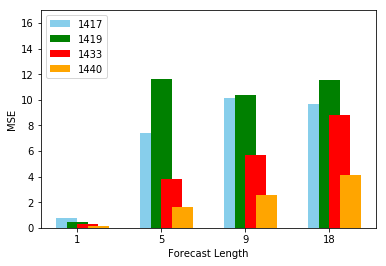

In [183]:
def result_loader():
    """Reading data from keys"""
    with open("results/knn/keys.txt", "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("results/knn/results_{}.csv".format(str(key)))

    return dictex

results = result_loader()
graph_data = dict()
std_data = dict()
keys = [1417, 1419, 1433, 1440]

for key in keys:
    d = []
    st = []
    for i in [1, 5, 9, 18]:
        t = sum(results[(key, i)].values) / float(len(results[(key, i)]))
        s = np.std(results[(key, i)])[1]
        d.append(t[1])
        st.append(s)
    graph_data[key] = d
    std_data[key] = st

# Data for plotting
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ind = np.arange(len(graph_data[1417]))  # the x locations for the groups
width = 0.25  # the width of the bars
all_means = []

means, std = np.around(graph_data[1417], decimals=3), np.around(std_data[1417], decimals=3)
ax.bar(ind - width/2, means, width, yerr=std,
            color='SkyBlue', label=1417, align='center')
all_means.append(means)

means, std = np.around(graph_data[1419], decimals=3), np.around(std_data[1419], decimals=3)
ax.bar(ind, means, width, yerr=std,
            color='Green', label=1419, align='center')
all_means.append(means)


means, std = np.around(graph_data[1433], decimals=3), np.around(std_data[1433], decimals=3)
ax.bar(ind + width/2, means, width, yerr=std,
            color='Red', label=1433, align='center')
all_means.append(means)


means, std = np.around(graph_data[1440], decimals=3), np.around(std_data[1440], decimals=3)
ax.bar(ind + width/2 + width/2, means, width, yerr=std,
            color='Orange', label=1440, align='center')
all_means.append(means)


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MSE')
ax.set_xlabel('Forecast Length')
ax.set_xticks(ind)
ax.set_xticklabels((1, 5, 9, 18))
ax.set_ylim([0, 17])
ax.legend(loc=2)


def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')


#autolabel(rects1, "left")
#autolabel(rects2, "right")

plt.show()

In [59]:
import pandas as pd
import numpy as np

def loader2():
    """Reading data from keys"""
    with open("data2/keys.txt", "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("data2/data_{}.csv".format(str(key)))

    return dictex

def normalize(train, test):
    mean = train.mean(axis=0)    
    train -= mean
    std = train.std(axis=0)
    for i in range(len(std)):
        if (std[i] == 0.0):
            std[i] = 1.0
    train /= std

    test -= mean
    test /= std
    return train, test

In [62]:
def experiment2(model, data, key):
    X_train, X_test, y_train, y_test = getValues(data)
    X_train, X_test = normalize(X_train, X_test)

    error_scores = list()
    print(key)
    with open('models/knn/model_{}'.format(key), 'rb') as f:
        knn_model = pickle.load(f)

    predictions = forecast_knn(knn_model, X_test)
    true = y_test

    # report performance
    mse = mean_squared_error(true, predictions)
    print('Test MSE: %.3f' % (mse))
    error_scores.append(mse)
    #plotPredictions(key, true, predictions)
    
    return true, predictions, error_scores, knn_model

In [63]:
%matplotlib inline

df = loader2()

import warnings
warnings.filterwarnings('ignore')

trueVals = []
predictedVals = []
results = dict()

def allowed_key(key):
    if  1 in key or 5 in key or 9 in key or 18 in key:
            return True
    return False

for key in df.keys():
    if allowed_key(key):
        true, predictions, error_scores, knn_model = experiment2(models[key], df[key], key)
        results[key] = error_scores
        print(error_scores)
        trueVals.extend(true)
        predictedVals.extend(predictions)

(1419, 1)
Test MSE: 3.970
[3.970079161261567]
(1419, 5)
Test MSE: 186.714
[186.71402217839758]
(1419, 9)
Test MSE: 455.193
[455.19258484595133]
(1419, 18)
Test MSE: 492.723
[492.72344046599085]
(1433, 1)
Test MSE: 2.407
[2.4074741915297753]
(1433, 5)
Test MSE: 70.226
[70.22594997744554]
(1433, 9)
Test MSE: 123.528
[123.5275980809583]
(1433, 18)
Test MSE: 123.401
[123.40109197247608]
(1440, 1)
Test MSE: 1.133
[1.1327820291962607]
(1440, 5)
Test MSE: 20.512
[20.512264346851563]
(1440, 9)
Test MSE: 60.833
[60.83289983323716]
(1440, 18)
Test MSE: 92.849
[92.84884760128007]
(1417, 1)
Test MSE: 6.922
[6.922254116346827]
(1417, 5)
Test MSE: 134.878
[134.87784455172536]
(1417, 9)
Test MSE: 302.704
[302.703711556033]
(1417, 18)
Test MSE: 392.315
[392.3145575559429]


In [64]:
import csv

def saver(dictex):
    for key, val in dictex.items():
        val = pd.DataFrame(val)
        val.to_csv("results2/knn/results_{}.csv".format(str(key)))

    with open("results2/knn/keys.txt", "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))
        
saver(results)

In [18]:
results = dict()
df = loader()

def allowed_key(key):
    if  1 in key or 5 in key or 9 in key or 18 in key:
            return True
    return False

for key in df.keys():
    if allowed_key(key):
        is_below_one = 0
        is_below_five = 0
        is_below_ten = 0
        is_below_twenty = 0
        is_above_twenty = 0
        for val in df[key]['surf_temp_sqerror'][-int(len(df[key]['surf_temp_sqerror']) * .3):]:
            if (val <= 1):
                is_below_one += 1
            elif (1 < val <= 5):
                is_below_five += 1
            elif (5 < val <= 10):
                is_below_ten += 1
            elif (10 < val <= 20):
                is_below_twenty += 1
            else:
                is_above_twenty += 1
        results[key] = (is_below_one, is_below_five, is_below_ten, is_below_twenty, is_above_twenty)

In [5]:
means = []

for key in df.keys():
    if allowed_key(key):
        means.append(np.mean(df[key]['surf_temp_sqerror']))
        
np.mean(means)

1.472554949844182

In [172]:
np.mean(all_means)

5.564562499999999

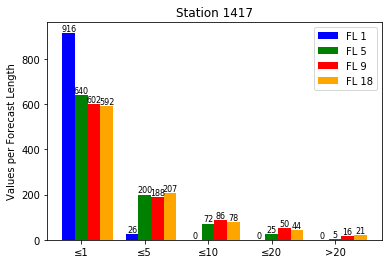

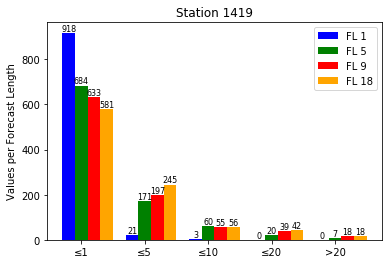

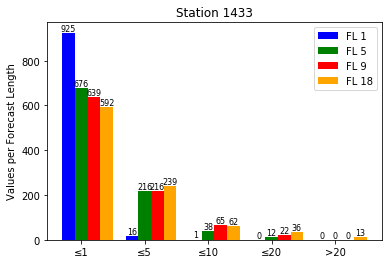

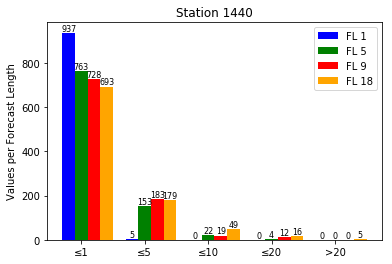

In [19]:
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import datetime

for key in [1417, 1419, 1433, 1440]:
    x = ['≤1', '≤5', '≤10', '≤20', '>20']
    ind = np.arange(len(x))

    y = results[(key, 1)]
    z = results[(key, 5)]
    k = results[(key, 9)]
    d = results[(key, 18)]

    ax = plt.subplot(111)

    ax.set_ylabel('Values per Forecast Length')
    ax.set_title('Station {}'.format(str(key)))
    ax.set_xticks(ind)
    ax.set_xticklabels(('≤1', '≤5', '≤10', '≤20', '>20'))

    bar1 = ax.bar(ind-0.2, y, width=0.2, color='b', align='center', label='FL 1')
    bar2 = ax.bar(ind, z, width=0.2, color='g', align='center', label='FL 5')
    bar3 = ax.bar(ind+0.2, k, width=0.2, color='r', align='center', label='FL 9')
    bar4 = ax.bar(ind+0.4, d, width=0.2, color='orange', align='center', label='FL 18')
    ax.legend(loc=1)
    
    # Add counts above the two bar graphs
    for rect in bar1 + bar2 + bar3 + bar4:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom', fontsize=8)

    plt.savefig('sse_values_30_percent_{}.png'.format(str(key)))
    plt.show()